In [1]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import string
import regex
import nltk
import re
%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopword = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample,shuffle
from sklearn.pipeline import Pipeline
from sklearn import linear_model

#### Задание 1.
Предсказать цену по описанию товара (для каждого товара)

In [3]:
df = pd.read_csv('Shoes_Data.csv', sep = ',')
for row in range(0, len(df)):
  df['price'].loc[row] = df['price'].loc[row].lstrip('₹')
  df['price'].loc[row] = float(df['price'].loc[row])
df_1 = df[['price', 'product_description']]

Оставила в рабочем датафрейме только колонки *price* и *product_description*. Убрала дубликаты. Дальше я убрала все нелатинские символы, предварительно посчитав, сколько таких описаний. Можно заметить, что текстов не на латинице достаточно мало, и их удаление не испортит нашу модель (см. графики ниже). 




In [4]:
df_1 = df_1.drop_duplicates()
df_1['index']= range(0, len(df_1))
df_1 = df_1.set_index('index')

def latin(df, column):
    nonenglish = 0
    english = 0
    length = []
    length_all = []
    for row in range(len(df[column])):
        text = df.loc[row, column]
        length_all.append(len(text.split()))
        if text.isascii() == False:
            nonenglish += 1
        else:
            english += 1
        encoded_string = text.encode("ascii", "ignore")
        decode_string = encoded_string.decode()
        decode_string = re.sub(r'\s+', ' ', decode_string)
        df.loc[row, column] = decode_string
        length.append(len(decode_string.split()))
    nonlatin = column + ' не полностью на латинице:' + str(nonenglish)
    lat = column +  ' полностью на латинице:' + str(english)
    return df, nonlatin, lat, length_all, length

In [5]:
df_1, nonlatin, lat, length_all, length = latin(df_1, 'product_description')
print(nonlatin, lat)
df_1.head()

product_description не полностью на латинице:178 product_description полностью на латинице:791


,price,product_description
index,,
0,279,Elevate your style with this classy pair of Ru...
1,479,The product will be an excellent pick for you....
2,430,Flaunt with these stylish and unique red casua...
3,499,Robbie Jones Shoes Are Designed To Keeping In ...
4,499,Sparx is a spectacular range of footwear from ...


Два ящика с усами: на обоих графиках показано распределение длин описаний товара. 

1.   Распределение значений длин при описаниях с не латинскими символами. Выбросов достаточно много.
2.   Распределение значений при описаниях только на латинице.

Оба ящика выглядят одинаково, тк значения там в 80% случаях совпадают (из данных выше о кол-ве описаний на латинице/ не латинице). Нас не интересуют выбросы, т.е очень длинные описания, потому что они не сопоставимы с теми, что только на латинице. Поэтому можно смело их удалить и дальше использовать только очищенные от не латиницы тексты.


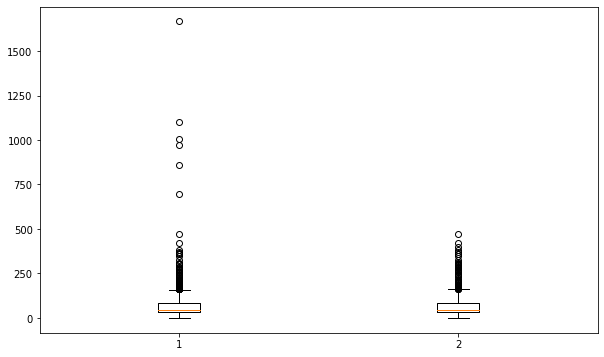

медиана длин описаний только на латинице: 46
максимальная длина описаний только на латинице: 472
минимальная длина описаний только на латинице: 0
медиана длин описаний со всеми символами: 46
максимальная длина описаний со всеми символами: 1666
минимальная длина описаний со всеми символами: 0


In [6]:
plt.figure(figsize=(10, 6))
plt.boxplot([length_all, length])
plt.show()

print('медиана длин описаний только на латинице:', statistics.median(length))
print('максимальная длина описаний только на латинице:', max(length))
print('минимальная длина описаний только на латинице:', min(length))
print('медиана длин описаний со всеми символами:', statistics.median(length_all))
print('максимальная длина описаний со всеми символами:', max(length_all))
print('минимальная длина описаний со всеми символами:', min(length_all))

Дальше идет лемматизация описаний, удаление стоп-слов, пунктуации, цифр. Я попробовала сделать такую предобработку, а затем сравнила с необработанными данными (см график ниже). Я сравнивала только кол-во токенов VS кол-во лем в описании по отношению к цене товара. Что я заметила:
*   Благодаря предпроцессингу текстов, данные по описаниям получаются более равномерными
*   Кажется, что линейной зависимости нет, короткие описания характерны для всех ценовых категорий товара
*   С другой стороны, похоже, что чем длиннее отзыв - тем ниже цена, а для наибольших цен вообще не характерны длинные описания



In [7]:
def preprocessing(anydf, column):
    anydf[column + '_lems'] = ''
    lem_length = []
    desc_length = []
    for row in range(len(anydf[column])):
        text = anydf[column][row]
        text = str(text)
        desc_length.append(len(text.split())) 
        tokens = nltk.word_tokenize(text.lower())
        lems = [lemmatizer.lemmatize(w) for w in tokens]
        lems = [lem for lem in lems if lem not in stopword
                  and lem != " "
                  and len(lem) >= 3
                  and lem.strip() not in punctuation
                  and lem.isdigit() is False]
        lems = [i for i in lems if not any(j.isdigit()
              or j in punctuation for j in i)]
        text = " ".join(lems)
        anydf[column + '_lems'][row] = text
        lem_length.append(len(text.split()))
    return anydf, lem_length, desc_length

In [8]:
df_1, lem_length, desc_length = preprocessing(df_1, 'product_description')
df_1.head()

,price,product_description,product_description_lems
index,,,
0,279,Elevate your style with this classy pair of Ru...,elevate style classy pair running shoe house c...
1,479,The product will be an excellent pick for you....,product excellent pick ensures easy maintenance
2,430,Flaunt with these stylish and unique red casua...,flaunt stylish unique red casual shoe per late...
3,499,Robbie Jones Shoes Are Designed To Keeping In ...,robbie jones shoe designed keeping mind durabi...
4,499,Sparx is a spectacular range of footwear from ...,sparx spectacular range footwear house relaxo ...


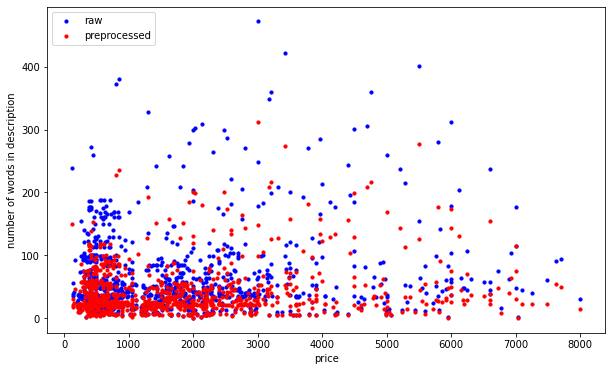

In [9]:
price = df_1['price'].tolist()
x = price
y = desc_length
v = lem_length
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', label='raw')
ax1.scatter(x, v, s=10, c='r', label='preprocessed')
ax1.set_xlabel('price')
ax1.set_ylabel('number of words in description')
plt.legend(loc='upper left');
plt.show()

Инициализирую два векторайзера (CountVectorizer, TfidfVectorizer). Ф-ция для оценки работы моделей линейной регрессии. 

In [10]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2))
x1 = bow_vectorizer.fit_transform(df_1['product_description_lems'])
y1 = df_1['price']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1)

In [11]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
x2 = tfidf_vectorizer.fit_transform(df_1['product_description_lems'])
y2 = df_1['price']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2)

In [12]:
def get_cv_scores(model, x_train, y_train, y_true, y_pred):
    scores = cross_val_score(model,
                             x_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE (0 is cool): ', mae)
    mse = mean_squared_error(y_true, y_pred)
    print('MSE (0 is cool): ', mse)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE (0 is cool): ', rmse)
    r2 = r2_score(y_true, y_pred)
    print('R2 (1 is cool): ', r2)
    cvmean = np.mean(scores)
    print('CV Mean (mean r2): ', cvmean)
    std = np.std(scores)
    print('STD (standart derivation): ', std)
    return model, mae, mse, rmse, r2, cvmean, std

Для предсказания цены я взяла модели: linearregression, ridge, lasso (elastic-net фитилась 15 минут и давала результаты не лучше чем другие модели, я ее удалила). В качестве векторайзера я попробовала сразу оба, чтобы сравнить результаты не только между моделями, но и по векторайзерам.

**Линейная регрессия** 


In [13]:
lr = LinearRegression(fit_intercept=False, normalize=True).fit(x_train1, y_train1)
lr_y_pred1 = lr.predict(x_test1)
lr_bow = get_cv_scores(lr, x_train1, y_train1, y_test1, lr_y_pred1)
print('\n')
lr = LinearRegression(fit_intercept=False, normalize=True).fit(x_train2, y_train2)
lr_y_pred2 = lr.predict(x_test2)
lr_tfidf = get_cv_scores(lr, x_train2, y_train2, y_test2, lr_y_pred2)

MAE (0 is cool):  1059.4395922591527
MSE (0 is cool):  2859485.964543999
RMSE (0 is cool):  1691.0014679307642
R2 (1 is cool):  -0.18724366489595012
CV Mean (mean r2):  -0.21331214016209316
STD (standart derivation):  0.267668913534754


MAE (0 is cool):  799.2867415642276
MSE (0 is cool):  1782952.6636825884
RMSE (0 is cool):  1335.2725054020202
R2 (1 is cool):  0.2557133617436188
CV Mean (mean r2):  0.25597174402818695
STD (standart derivation):  0.03700302692429087


**Регрессия Ridge** 

In [14]:
ridge1 = Ridge(alpha=1).fit(x_train1, y_train1)
ridge2 = Ridge(alpha=1).fit(x_train2, y_train2)
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge1, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result_1 = grid.fit(x_train1, y_train1)
print('Best Score for BoW: ', grid_result_1.best_score_)
print('Best Params for BoW: ', grid_result_1.best_params_)
print('\n')
grid = GridSearchCV(estimator=ridge2, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result_2 = grid.fit(x_train2, y_train2)
print('Best Score for TfIdf: ', grid_result_2.best_score_)
print('Best Params for TfIdf: ', grid_result_2.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score for BoW:  0.3822066377764751
Best Params for BoW:  {'alpha': 100}


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for TfIdf:  0.43764255432018195
Best Params for TfIdf:  {'alpha': 0.1}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished


In [15]:
ridge_y_pred1 = grid_result_1.predict(x_test1)
ridge_y_pred2 = grid_result_2.predict(x_test2)

In [16]:
ridge_bow = get_cv_scores(ridge1, x_train1, y_train1, y_test1, ridge_y_pred1)
print('\n')
ridge_tfidf = get_cv_scores(ridge2, x_train2, y_train2, y_test2, ridge_y_pred2)

MAE (0 is cool):  764.5667985285793
MSE (0 is cool):  1297643.1841416801
RMSE (0 is cool):  1139.1414241180416
R2 (1 is cool):  0.46122531504948294
CV Mean (mean r2):  0.2319392620106005
STD (standart derivation):  0.1424613318512512


MAE (0 is cool):  709.8323935924094
MSE (0 is cool):  1117498.0721992652
RMSE (0 is cool):  1057.1178137744464
R2 (1 is cool):  0.5335047865503799
CV Mean (mean r2):  0.42045952786732255
STD (standart derivation):  0.037822478888996605


**Регрессия Lasso**

In [17]:
lasso1 = Lasso(alpha=1).fit(x_train1, y_train1)
lasso2 = Lasso(alpha=1).fit(x_train2, y_train2)
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso1, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result1 = grid.fit(x_train1, y_train1)
print('Best Score: ', grid_result1.best_score_)
print('Best Params: ', grid_result1.best_params_)
print('\n')
grid = GridSearchCV(estimator=lasso2, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result2 = grid.fit(x_train2, y_train2)
print('Best Score: ', grid_result2.best_score_)
print('Best Params: ', grid_result2.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236963.9123043567, tolerance: 184613.4862512672
  max_iter, tol, rng, random, positive)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.7min finished


Best Score:  0.3512109342343957
Best Params:  {'alpha': 10}


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.2min finished


Best Score:  0.44272794368491086
Best Params:  {'alpha': 1}


In [18]:
lasso_y_pred1 = grid_result1.predict(x_test1)
lasso_y_pred2 = grid_result2.predict(x_test2)

In [19]:
lasso_bow = get_cv_scores(lasso1, x_train1, y_train1, y_test1, lasso_y_pred1)
print('\n')
lasso_tfidf = get_cv_scores(lasso2, x_train2, y_train2, y_test2, lasso_y_pred2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 400450.31763498485, tolerance: 140220.22410093795
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1449336.7835159153, tolerance: 144737.8126097074
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156809.7494570464, tolerance: 149794.77460385548
  max_iter, tol, rng, random, positive)


MAE (0 is cool):  860.6348270820691
MSE (0 is cool):  1543639.4444467572
RMSE (0 is cool):  1242.4328732155943
R2 (1 is cool):  0.35908895024243537
CV Mean (mean r2):  0.2284383589323573
STD (standart derivation):  0.13943327658676233


MAE (0 is cool):  774.9838875934801
MSE (0 is cool):  1258350.8701603874
RMSE (0 is cool):  1121.7623946988003
R2 (1 is cool):  0.4747063351843417
CV Mean (mean r2):  0.44272794368491086
STD (standart derivation):  0.04710078737772223


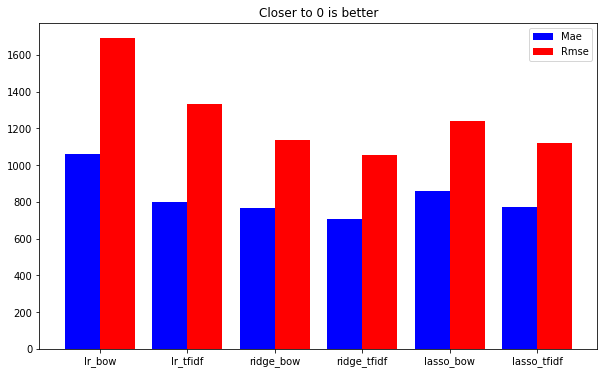

In [20]:
fig = plt.figure(figsize=(10, 6))

X = ['lr_bow', 'lr_tfidf', 'ridge_bow',
      'ridge_tfidf', 'lasso_bow', 'lasso_tfidf']
xmaes = [lr_bow[1], lr_tfidf[1], ridge_bow[1],
        ridge_tfidf[1], lasso_bow[1], lasso_tfidf[1]]
yrmses = [lr_bow[3], lr_tfidf[3], ridge_bow[3],
        ridge_tfidf[3], lasso_bow[3], lasso_tfidf[3]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, xmaes, 0.4, color = 'b', label = 'Mae')
plt.bar(X_axis + 0.2, yrmses, 0.4, color = 'r', label = 'Rmse')
  
plt.xticks(X_axis, X)
plt.title("Closer to 0 is better")
plt.legend()
plt.show()

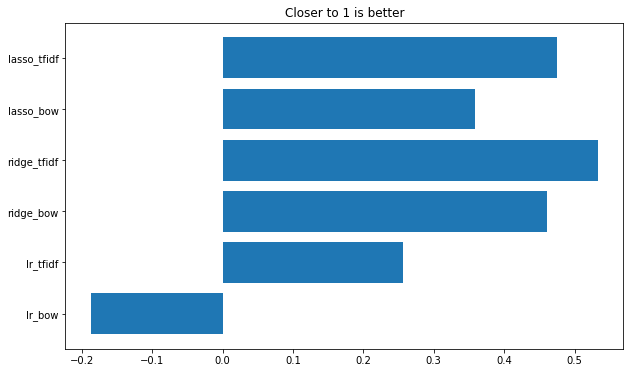

In [21]:
fig = plt.figure(figsize=(10, 6))
x = ['lr_bow', 'lr_tfidf', 'ridge_bow',
      'ridge_tfidf', 'lasso_bow', 'lasso_tfidf']
y = [lr_bow[4], lr_tfidf[4], ridge_bow[4],
        ridge_tfidf[4], lasso_bow[4], lasso_tfidf[4]]

plt.title("Closer to 1 is better")
plt.barh(x, y)
plt.show()

Вывод по результатам моделей: лучше всех по всем метрикам оказалась модель **Ridge regression** с CountVectorizer и TfidfVectorizer, хотя Lasso Regression несильно уступает ей. Хуже всех справились модель простой линейной регрессии и CountVectorizer (в совокупности в том числе). Очевидно, простая линейная регрессия не справится с таким большим разбросом данных. Модели Ridge regression и Lasso Regression помогает бороться с псевдозависимостью между переменными, которыми могли быть выбросы. 

**Комментарии к 1 заданию**

Так как инструментов много, а данные несбалансированные, я перечислю то, что, как мне кажется, может улучшить существующие модели в данной задаче:

*   Сбалансировать данные. Например, выставить верхнюю границу длины отзывов или наоброт добавить дубликатов с длинными отзывами.
*   Можно попробовать другие способы лемматизации текстов (другие библиотеки), не убирать стоп-слова.
*   При векторизации можно выставить n-граммы в параметрах (я взяла n-граммы от 1 до 2, но можно и другие проверить), а также покрутить другие параметры. Можно внедрить в гридсерч векторайзеры, чтобы не считать вручную результаты для каждого (но для меня это показалось легче, так как я знаю, как это делать).
*   Мне кажется, если использовать названия товаров (колонка title), можно лучше предсказать цену. Это связано с тем, что некоторые бренды дороже, а другие дешевле сами по себе.



#### Задание 2.
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

Сначала я разделила отзывы из изначального датафрейма на отдельные строки с отзывами. Затем я посчитала кол-во нелатиницы в отзывах и убрала все нелатинские символы. Препроцессинг я сделала тот же, что и в задаче с регрессией, но я оставила стоп-слова и слова меньше длины 3. Например, *not* может помочь модели отнести отзыв к негативному (возможно даже есть устойчивые характерные словосочетания типа 'not very' или подобные). В любом случае, результат стал от этого лучше (f1-score повышается примерно на 0.05, что существенно!).

In [22]:
df_2 = df[['reviews', 'reviews_rating']]
texts = []
ratings = []
for row in range(0, len(df_2)):
    texts.append(df_2['reviews'].loc[row].split('|| '))
    ratings.append(df_2['reviews_rating'].loc[row].split('|| '))
texts = [item for sublist in texts for item in sublist]
ratings = [item for sublist in ratings for item in sublist]

In [23]:
data = {'review': texts, 'rating': ratings}   
df_2 = pd.DataFrame(data)
for row in range(0, len(df_2)):
    df_2['rating'][row] = float(df_2['rating'].loc[row].split(' ')[0])

In [24]:
df_2 = df_2.drop_duplicates(ignore_index=True)
nonenglish = 0
english = 0
length = []
length_all = []
for row in range(len(df_2['review'])):
    text = df_2.loc[row, 'review']
    length_all.append(len(text.split()))
    if text.isascii() == False:
        nonenglish += 1
    else:
        english += 1
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    decode_string = re.sub(r'\s+', ' ', decode_string)
    df_2.loc[row, 'review'] = decode_string
    length.append(len(decode_string.split()))
nonlatin = 'review не полностью на латинице:' + str(nonenglish)
lat = 'review полностью на латинице:' + str(english)

Отзывов с нелатиницей оказалось мало.

In [25]:
print(nonlatin, lat)

review не полностью на латинице:309 review полностью на латинице:5030


In [26]:
df_2['review_lems'] = ''
lem_len = []
rev_len = []
for row in range(0, len(df_2)):
    text = df_2['review'].loc[row]
    text = str(text)
    rev_len = [].append(len(text.split())) 
    tokens = nltk.word_tokenize(text.lower())
    lems = [lemmatizer.lemmatize(w) for w in tokens]
    lems = [lem for lem in lems if lem != " "
        and lem.strip() not in punctuation
        and lem.isdigit() is False]
    lems = [i for i in lems if not any(j.isdigit()
            or j in punctuation for j in i)]
    text = " ".join(lems)
    df_2['review_lems'][row] = text
    lem_len = [].append(len(text.split()))
df_2.drop(df_2.loc[df_2['review']==''].index, inplace=True)
df_2.drop(df_2.loc[df_2['review']==''].index, inplace=True)
df_2.head()

,review,rating,review_lems
0,Not happy with product,1,not happy with product
1,It's not as expected.,1,it not a expected
2,AVERAGE PRODUCT,3,average product
3,Pic more beautiful,3,pic more beautiful
4,Got damage product. But quality is average for...,3,got damage product but quality is average for


Ниже представлен график распределения кол-ва отзывов по оценкам. Кол-во отзывов на оценку 5 сильно превышает все остальные, что может сбить модель с толку, т.е более частое и точное предсказывание отзывов на 5, чем, например, на 2. Я попробовала зафитить такие данные в модель и получила f1-score около 0.40 (очень мало!!). В итоге я решила все же добавить данных в малочисленные классы, и обучить (только обучить!) модель на таких данных.

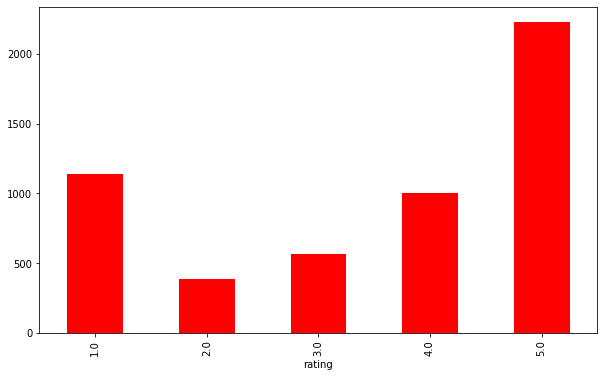

In [27]:
df_2['rating'] = pd.to_numeric(df_2['rating'])
fig = plt.figure(figsize=(10, 6))
df_2.groupby('rating').review.count().plot.bar(ylim=0, color = 'r')
plt.show()

In [28]:
train, test = train_test_split(df_2, test_size=0.2, random_state=42)

In [29]:
train_1 = train[train['rating'] == 1]
train_2 = train[train['rating'] == 2]
train_3 = train[train['rating'] == 3]
train_4 = train[train['rating'] == 4]
train_5 = train[train['rating'] == 5]

train_1_new = resample(train_1,random_state=42,n_samples=1800,replace=True)
train_2_new = resample(train_2,random_state=42,n_samples=1800,replace=True)
train_3_new = resample(train_3,random_state=42,n_samples=1800,replace=True)
train_4_new = resample(train_4,random_state=42,n_samples=1800,replace=True)

train_new = pd.concat([train_5, train_1_new, train_2_new, train_3_new,
                       train_4_new])

Этот график показывает, что train data сбалансирована по всем классам, все красиво.

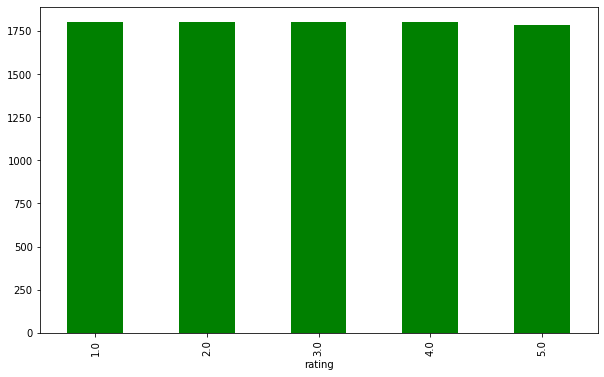

In [30]:
fig = plt.figure(figsize=(10, 6))
train_new.groupby('rating').review.count().plot.bar(ylim=0, color = 'g')
plt.show()

Я взяла две модели: KNeighborsClassifier и Multinomial Naive Bayes. Это самые базовые модели для мультиклассовой классификации (+ можно взять Random Forest и Gradient Boosting). Кроме того, есть адапторы бинарных классификаторов для мультиклассификации - OneVsOneClassifier и его друзья, их я не брала, но как вариант.

! В первом задании я отдельно векторизовала тексты, а тут я положила TfidfVectorizer и CountVectorizer в пайплайн, чтобы гридсерч сам подсказал, как лучше векторизовать. НО такой способ занимает больше времени, тк перебираются всевозможные вариации параметров.

**KNN** 

In [31]:
knn = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('knn', KNeighborsClassifier())])


param_knn = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
             'tfidf__use_idf': (True, False),
             'knn__n_neighbors': np.arange(1, 30),
             'knn__weights': ('uniform', 'distance')}
               
knn_gscv = GridSearchCV(knn, param_knn, n_jobs=-1, scoring = 'f1_weighted')
grid_results = knn_gscv.fit(train_new['review_lems'], train_new['rating'])
print(grid_results.best_score_)
print(grid_results.best_params_)

0.8106348180680577
{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'tfidf__use_idf': False, 'vectorizer__ngram_range': (1, 2)}


**Multinomial Naive Bayes**

In [32]:
nb = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('nb', MultinomialNB())])


param_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'nb__fit_prior': (True, False),
               'nb__alpha': (100, 10, 1, 0.1, 0.01, 0.001, 0)}
               
nb_gscv = GridSearchCV(nb, param_nb, n_jobs=-1, scoring = "f1_weighted")
nb_gscv = nb_gscv.fit(train_new['review_lems'], train_new['rating'])
print(nb_gscv.best_score_)
print(nb_gscv.best_params_)

0.7520884568074219
{'nb__alpha': 0, 'nb__fit_prior': True, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False, 'vectorizer__ngram_range': (1, 2)}


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Теперь посмотрим на результаты моделей на тестовой несбалансированной части отзывов. Результаты гораздо хуже, чем при обучении модели, но это ожидаемо. Внезапно у модели NB с худшим результатом на тестовых данных получились лучше результаты на тестовых данных.

In [33]:
y_pred_knn = knn_gscv.predict(test['review_lems'])
y_true_knn = test['rating']
print('f1score for KNN', f1_score(y_true_knn, y_pred_knn, average='weighted'))
y_pred_nb = nb_gscv.predict(test['review_lems'])
y_true_nb = test['rating']
print('f1score for nb', f1_score(y_true_nb, y_pred_nb, average='weighted'))

f1score for KNN 0.4369554176438655
f1score for nb 0.5050921879321798


Confusion Matrix для модели Multinomial Naive Bayes. Модель лучше всего справилась с распознаванием оценок 5 и 1, что коррелирует с изначальным распределением данных. 

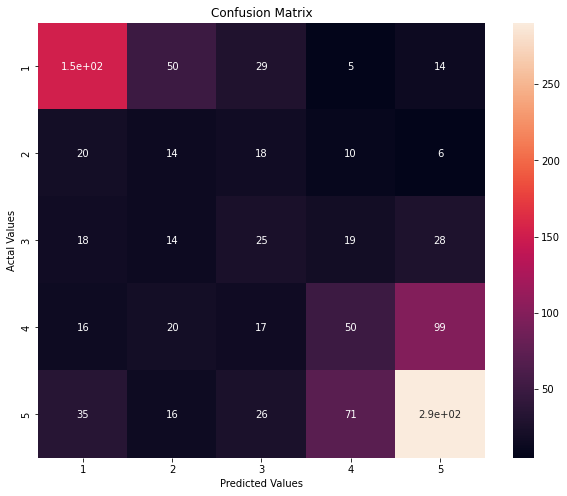

In [34]:
cm = confusion_matrix(y_true_nb, y_pred_nb)
cm_df = pd.DataFrame(cm,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

**Комментарии к 2 заданию**

Несмотря на хорошие результаты в гридсерче, модель не справилась с несбалансированными данными на тестовых данных. *Почему так могло случиться:*
*   Отзывы на оценки 1 и 5 - самые полярные, а значит самые красочные и разнообразные (мое предположение), поэтому дублирование или искусственное создание данных не поможет улучшить распознавание "скучных" отзывов на двоечку-четверочку.
*   Отзывы на 1 и 5 самые длинных (как следствие предыдущего пункта), а значит больше данных для модели.

*Как можно улучшить модель:*
*   Добавить отзывов с оценками 2-4.
*   Возможно, сбалансировать длины отзывов из разных классов. Я не проверяла распределение по средней длине в каждом классе, но я думаю, это было бы полезно.
*   Опробовать другие модели, например, OneVsOneClassifier и другие.
*   Чем больше классов для отзывов, тем меньше разница между соседними классами. Можно попробовать положить все отзывы на 2-4 в один класс и посмотреть на работу модели, хотя это уже другая история...






